# Customer Segmentation: RFM Analysis, CLV, dan Market Basket Analysis
## E-Commerce Customer Analytics

Project ini melakukan analisis komprehensif customer segmentation menggunakan:
1. **RFM Analysis** - Segmentasi berdasarkan Recency, Frequency, Monetary
2. **Customer Lifetime Value (CLV)** - Prediksi nilai customer
3. **Market Basket Analysis** - Analisis asosiasi produk

## 1. Import Libraries dan Load Dataset

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Untuk Market Basket Analysis
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load dataset
df = pd.read_csv('../E-Commerce Data.csv', sep=';', encoding='latin-1')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (541909, 8)

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,"3,39",17850.0,United Kingdom


In [3]:
# Info dataset
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("Statistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  object 
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB
None

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Statistical Summary:


,Quantity,CustomerID
count,541909.000000,406829.000000
mean,9.552250,15287.690570
std,218.081158,1713.600303
min,-80995.000000,12346.000000
25%,1.000000,13953.000000
50%,3.000000,15152.000000
75%,10.000000,16791.000000
max,80995.000000,18287.000000


## 2. Data Preprocessing dan Cleaning

In [4]:
# Copy dataframe untuk preprocessing
df_clean = df.copy()

# Convert UnitPrice dari string ke float (replace comma dengan dot)
df_clean['UnitPrice'] = df_clean['UnitPrice'].astype(str).str.replace(',', '.').astype(float)

# Convert InvoiceDate ke datetime (dengan format mixed untuk handle berbagai format)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], format='mixed', dayfirst=True)

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

print("Data sebelum cleaning:", df_clean.shape)
print("\nMissing values:")
print(df_clean.isnull().sum())

Data sebelum cleaning: (541909, 9)

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
TotalPrice          0
dtype: int64


In [5]:
# Data Cleaning
# 1. Remove missing CustomerID
df_clean = df_clean[df_clean['CustomerID'].notna()]

# 2. Remove negative quantities and prices (returns/cancellations)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# 3. Remove missing descriptions
df_clean = df_clean[df_clean['Description'].notna()]

# 4. Remove outliers (optional - top 1% of prices)
price_threshold = df_clean['TotalPrice'].quantile(0.99)
df_clean = df_clean[df_clean['TotalPrice'] <= price_threshold]

print("Data setelah cleaning:", df_clean.shape)
print("\nDate range:", df_clean['InvoiceDate'].min(), "to", df_clean['InvoiceDate'].max())
print("Number of unique customers:", df_clean['CustomerID'].nunique())
print("Number of unique products:", df_clean['StockCode'].nunique())
print("Number of unique invoices:", df_clean['InvoiceNo'].nunique())

Data setelah cleaning: (393915, 9)

Date range: 2010-01-12 08:26:00 to 2011-12-10 17:19:00
Number of unique customers: 4290
Number of unique products: 3662
Number of unique invoices: 18018


In [6]:
df_clean.head(100)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
97,536378,21975,PACK OF 60 DINOSAUR CAKE CASES,24,2010-01-12 09:37:00,0.55,14688.0,United Kingdom,13.20
98,536378,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2010-01-12 09:37:00,0.55,14688.0,United Kingdom,13.20
99,536378,84991,60 TEATIME FAIRY CAKE CASES,24,2010-01-12 09:37:00,0.55,14688.0,United Kingdom,13.20
100,536378,84519A,TOMATO CHARLIE+LOLA COASTER SET,6,2010-01-12 09:37:00,2.95,14688.0,United Kingdom,17.70


In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393915 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    393915 non-null  object        
 1   StockCode    393915 non-null  object        
 2   Description  393915 non-null  object        
 3   Quantity     393915 non-null  int64         
 4   InvoiceDate  393915 non-null  datetime64[ns]
 5   UnitPrice    393915 non-null  float64       
 6   CustomerID   393915 non-null  float64       
 7   Country      393915 non-null  object        
 8   TotalPrice   393915 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.1+ MB


## 2.1 Exploratory Data Analysis (EDA) - Pre-RFM

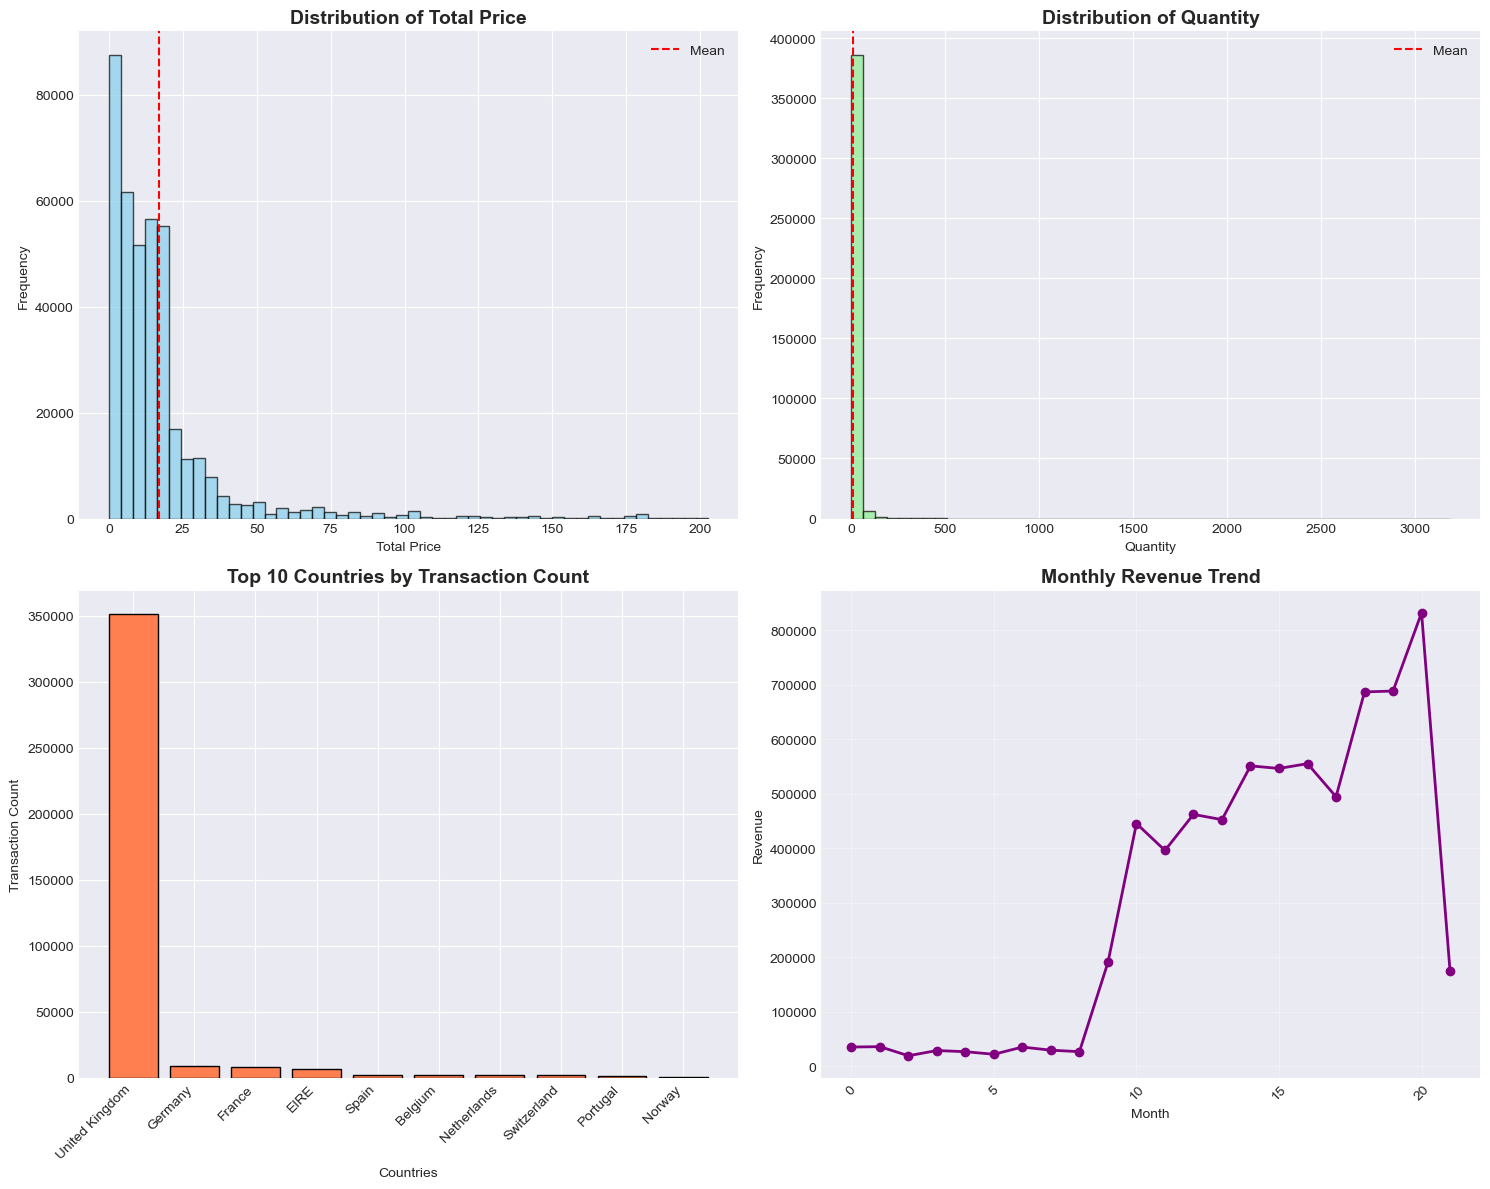

Dataset Statistics:
Total Revenue: $6,737,063.16
Average Order Value: $17.10
Total Transactions: 393,915
Unique Customers: 4,290
Unique Products: 3,662


In [10]:
# 2.1.1 Overview Dataset Setelah Cleaning
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of TotalPrice
axes[0, 0].hist(df_clean['TotalPrice'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Total Price', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_clean['TotalPrice'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Distribution of Quantity
axes[0, 1].hist(df_clean['Quantity'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Quantity', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_clean['Quantity'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Top 10 Countries by Transaction Count
country_counts = df_clean['Country'].value_counts().head(10)
axes[1, 0].bar(range(len(country_counts)), country_counts.values, color='coral', edgecolor='black')
axes[1, 0].set_title('Top 10 Countries by Transaction Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Countries')
axes[1, 0].set_ylabel('Transaction Count')
axes[1, 0].set_xticks(range(len(country_counts)))
axes[1, 0].set_xticklabels(country_counts.index, rotation=45, ha='right')

# Revenue by Month
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_clean.groupby('Month')['TotalPrice'].sum()
axes[1, 1].plot(range(len(monthly_revenue)), monthly_revenue.values, marker='o', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Revenue')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Dataset Statistics:")
print(f"Total Revenue: ${df_clean['TotalPrice'].sum():,.2f}")
print(f"Average Order Value: ${df_clean['TotalPrice'].mean():.2f}")
print(f"Total Transactions: {len(df_clean):,}")
print(f"Unique Customers: {df_clean['CustomerID'].nunique():,}")
print(f"Unique Products: {df_clean['StockCode'].nunique():,}")

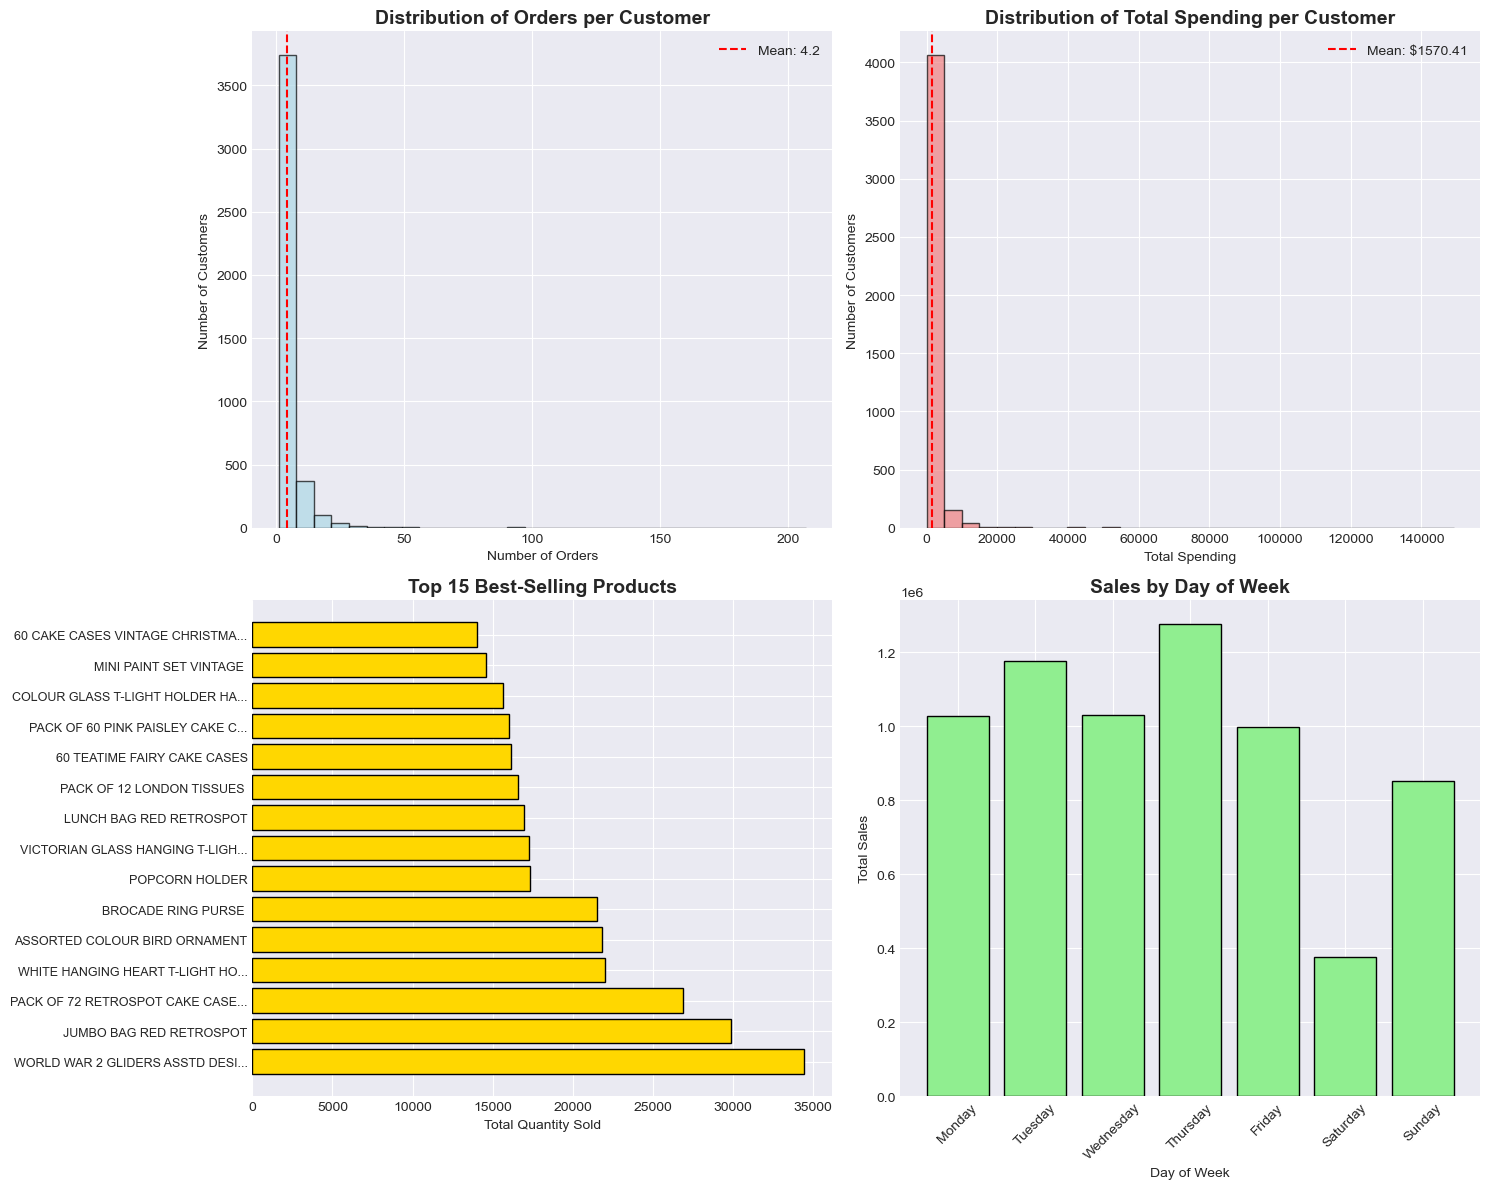

Customer Behavior Insights:
Average orders per customer: 4.2
Average spending per customer: $1570.41
Top spending customer: $149101.28
Most active day: Thursday ($1277814.51)


In [11]:
# 2.1.2 Customer Behavior Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Customer Frequency Distribution (Orders per Customer)
customer_orders = df_clean.groupby('CustomerID')['InvoiceNo'].nunique()
axes[0, 0].hist(customer_orders, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Orders per Customer', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(customer_orders.mean(), color='red', linestyle='--', label=f'Mean: {customer_orders.mean():.1f}')
axes[0, 0].legend()

# Customer Spending Distribution
customer_spending = df_clean.groupby('CustomerID')['TotalPrice'].sum()
axes[0, 1].hist(customer_spending, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Total Spending per Customer', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Total Spending')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(customer_spending.mean(), color='red', linestyle='--', label=f'Mean: ${customer_spending.mean():.2f}')
axes[0, 1].legend()

# Top 15 Best-Selling Products
top_products = df_clean.groupby('Description')['Quantity'].sum().nlargest(15)
axes[1, 0].barh(range(len(top_products)), top_products.values, color='gold', edgecolor='black')
axes[1, 0].set_title('Top 15 Best-Selling Products', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Quantity Sold')
axes[1, 0].set_yticks(range(len(top_products)))
axes[1, 0].set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc for desc in top_products.index], fontsize=9)

# Daily Sales Pattern
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
daily_sales = df_clean.groupby('DayOfWeek')['TotalPrice'].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = daily_sales.reindex(day_order)
axes[1, 1].bar(range(len(daily_sales)), daily_sales.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Sales by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Total Sales')
axes[1, 1].set_xticks(range(len(daily_sales)))
axes[1, 1].set_xticklabels(daily_sales.index, rotation=45)

plt.tight_layout()
plt.show()

print("Customer Behavior Insights:")
print(f"Average orders per customer: {customer_orders.mean():.1f}")
print(f"Average spending per customer: ${customer_spending.mean():.2f}")
print(f"Top spending customer: ${customer_spending.max():.2f}")
print(f"Most active day: {daily_sales.idxmax()} (${daily_sales.max():.2f})")

## 3. RFM Analysis 

In [8]:
# Set reference date (1 hari setelah transaksi terakhir)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print("Reference Date:", reference_date)

# Hitung RFM metrics
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nRFM Data shape:", rfm.shape)
print("\nRFM Statistics:")
print(rfm.describe())
print("\nSample RFM data:")
rfm.head(10)

Reference Date: 2011-12-11 17:19:00

RFM Data shape: (4290, 4)

RFM Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4290.000000  4290.000000  4290.000000    4290.000000
mean   15294.258974   106.129837     4.200000    1570.410994
std     1720.766627   114.653934     7.474935    4458.692751
min    12347.000000     1.000000     1.000000       2.900000
25%    13810.250000    23.000000     1.000000     296.655000
50%    15287.500000    61.000000     2.000000     653.030000
75%    16774.750000   162.000000     5.000000    1561.302500
max    18287.000000   698.000000   207.000000  149101.280000

Sample RFM data:


,CustomerID,Recency,Frequency,Monetary
0,12347.0,41,7,4060.40
1,12348.0,77,4,1557.24
2,12349.0,20,1,1457.55
3,12350.0,312,1,334.40
4,12352.0,74,8,1849.49
5,12353.0,205,1,89.00
6,12354.0,234,1,1079.40
7,12355.0,97,1,459.40
8,12356.0,24,3,2487.43
9,12357.0,183,1,5970.07


In [9]:
# Create RFM Scores (1-5 scale, 5 is best)
# Recency: lower is better, so reverse the score
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1])
# Frequency: higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
# Monetary: higher is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=[1, 2, 3, 4, 5])

# Convert to int
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create RFM Score (combined)
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print("RFM Scores created!")
print("\nRFM Score distribution:")
print(rfm['RFM_Score'].value_counts().sort_index())
rfm.head(10)

RFM Scores created!

RFM Score distribution:
RFM_Score
3     176
4     358
5     364
6     396
7     387
8     352
9     338
10    320
11    338
12    323
13    306
14    301
15    331
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12347.0,41,7,4060.40,4,5,5,14
1,12348.0,77,4,1557.24,3,4,4,11
2,12349.0,20,1,1457.55,4,1,4,9
3,12350.0,312,1,334.40,1,1,2,4
4,12352.0,74,8,1849.49,3,5,4,12
5,12353.0,205,1,89.00,1,1,1,3
6,12354.0,234,1,1079.40,1,1,4,6
7,12355.0,97,1,459.40,2,1,2,5
8,12356.0,24,3,2487.43,4,3,5,12
9,12357.0,183,1,5970.07,2,1,5,8


### 3.1 EDA Post-RFM Analysis

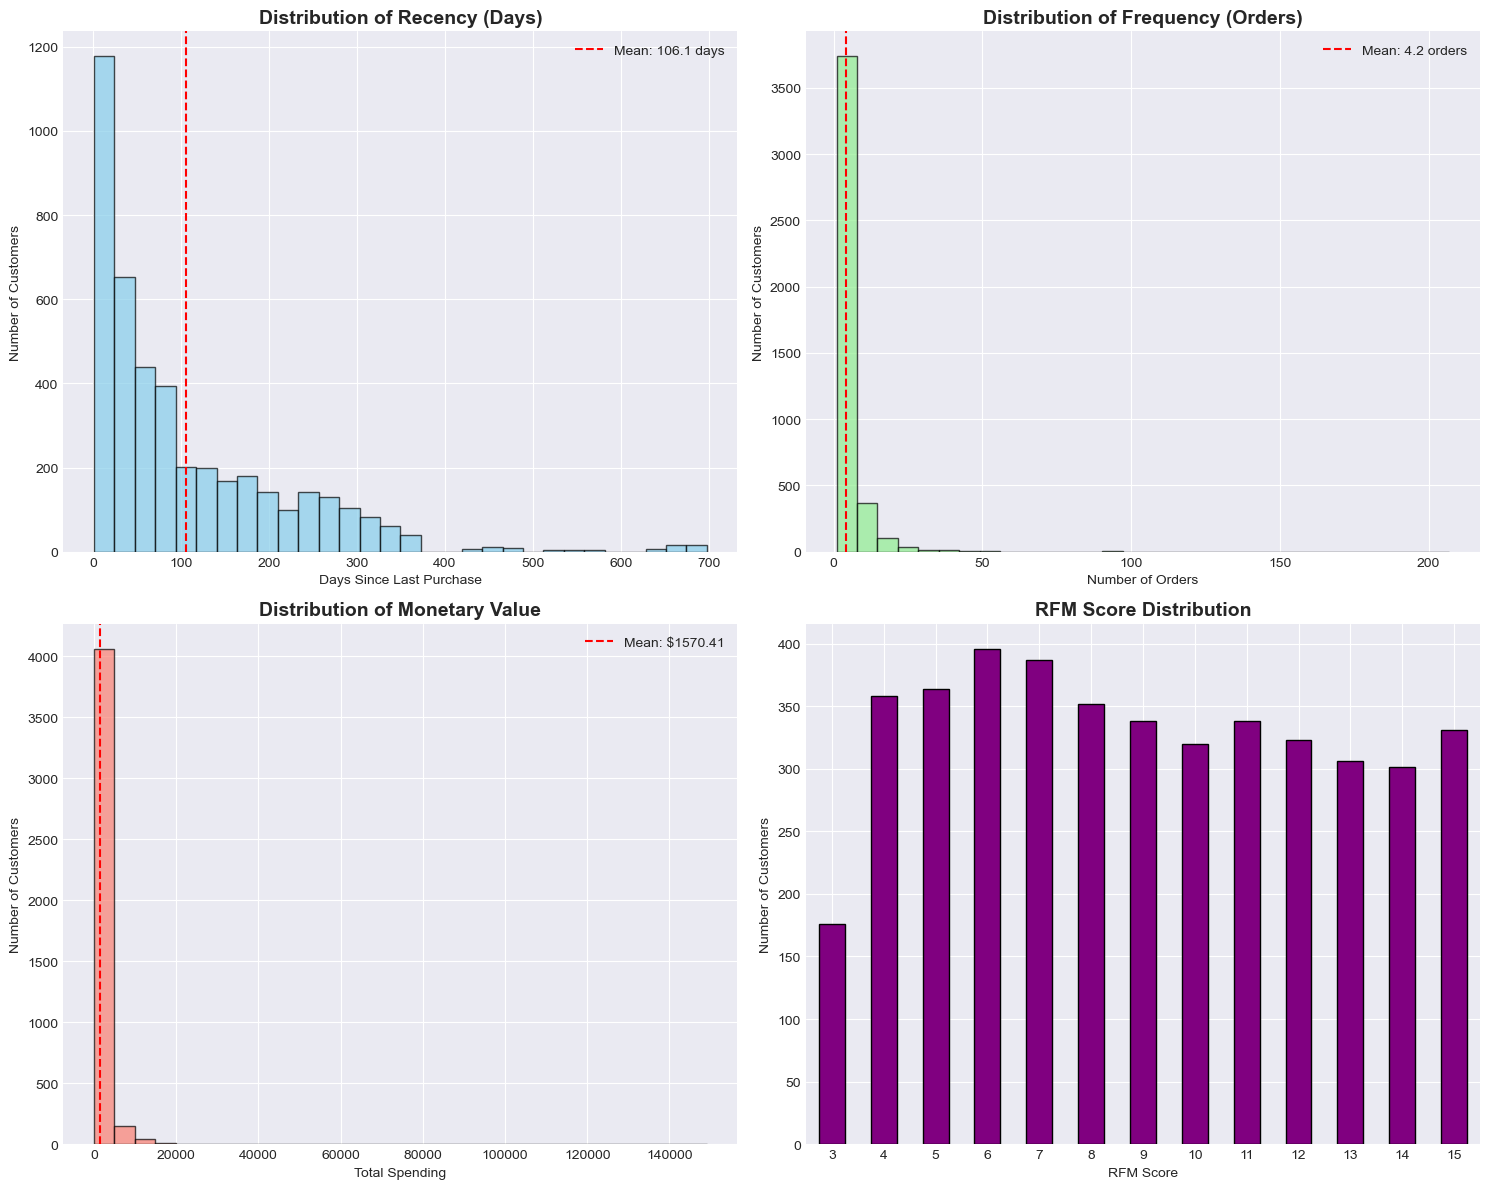

RFM Metrics Summary:
Recency - Min: 1 days, Max: 698 days, Mean: 106.1 days
Frequency - Min: 1, Max: 207, Mean: 4.2
Monetary - Min: $2.90, Max: $149101.28, Mean: $1570.41


In [12]:
# 3.1.1 RFM Metrics Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Recency Distribution
axes[0, 0].hist(rfm['Recency'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Recency (Days)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Days Since Last Purchase')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.1f} days')
axes[0, 0].legend()

# Frequency Distribution
axes[0, 1].hist(rfm['Frequency'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Frequency (Orders)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Orders')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f} orders')
axes[0, 1].legend()

# Monetary Distribution
axes[1, 0].hist(rfm['Monetary'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Monetary Value', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Spending')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].axvline(rfm['Monetary'].mean(), color='red', linestyle='--', label=f'Mean: ${rfm["Monetary"].mean():.2f}')
axes[1, 0].legend()

# RFM Score Distribution
rfm['RFM_Score'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], color='purple', edgecolor='black')
axes[1, 1].set_title('RFM Score Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('RFM Score')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("RFM Metrics Summary:")
print(f"Recency - Min: {rfm['Recency'].min()} days, Max: {rfm['Recency'].max()} days, Mean: {rfm['Recency'].mean():.1f} days")
print(f"Frequency - Min: {rfm['Frequency'].min()}, Max: {rfm['Frequency'].max()}, Mean: {rfm['Frequency'].mean():.1f}")
print(f"Monetary - Min: ${rfm['Monetary'].min():.2f}, Max: ${rfm['Monetary'].max():.2f}, Mean: ${rfm['Monetary'].mean():.2f}")

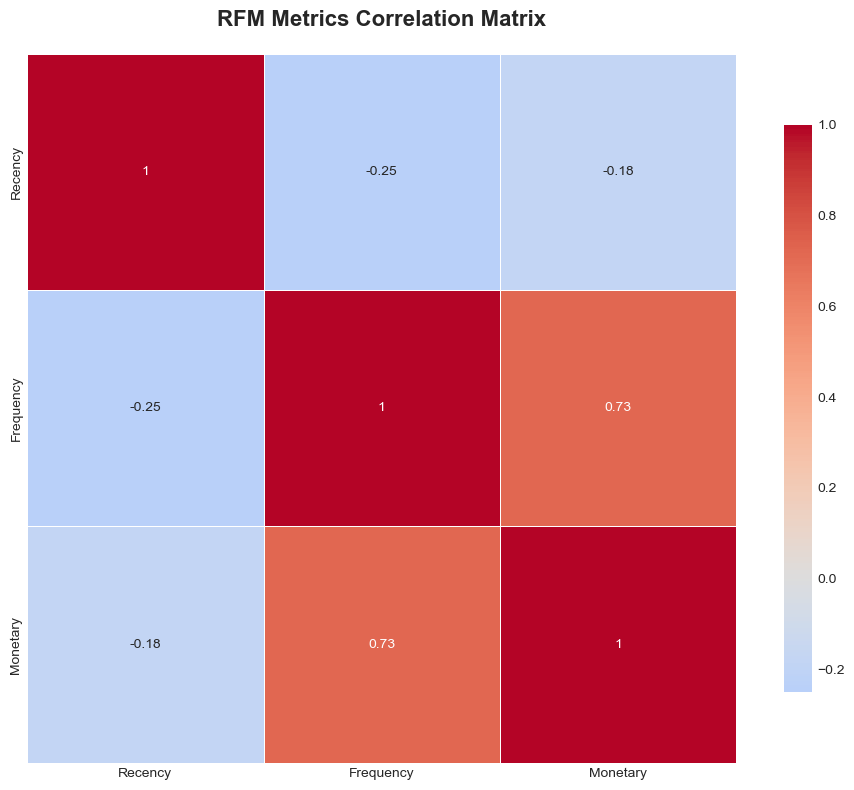

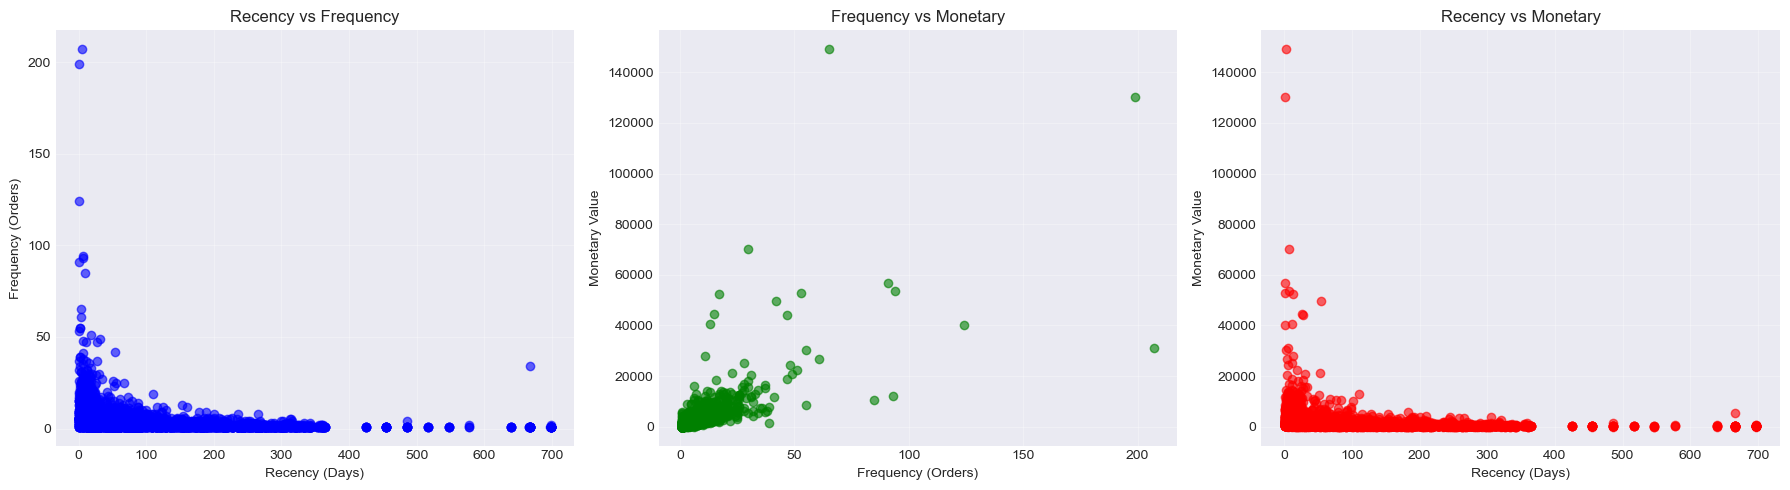

RFM Correlation Insights:
Recency vs Frequency correlation: -0.249
Recency vs Monetary correlation: -0.176
Frequency vs Monetary correlation: 0.725


In [13]:
# 3.1.2 RFM Correlation Analysis
correlation_matrix = rfm[['Recency', 'Frequency', 'Monetary']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('RFM Metrics Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# RFM Scatter Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency vs Frequency
scatter1 = axes[0].scatter(rfm['Recency'], rfm['Frequency'], alpha=0.6, c='blue')
axes[0].set_xlabel('Recency (Days)')
axes[0].set_ylabel('Frequency (Orders)')
axes[0].set_title('Recency vs Frequency')
axes[0].grid(True, alpha=0.3)

# Frequency vs Monetary
scatter2 = axes[1].scatter(rfm['Frequency'], rfm['Monetary'], alpha=0.6, c='green')
axes[1].set_xlabel('Frequency (Orders)')
axes[1].set_ylabel('Monetary Value')
axes[1].set_title('Frequency vs Monetary')
axes[1].grid(True, alpha=0.3)

# Recency vs Monetary
scatter3 = axes[2].scatter(rfm['Recency'], rfm['Monetary'], alpha=0.6, c='red')
axes[2].set_xlabel('Recency (Days)')
axes[2].set_ylabel('Monetary Value')
axes[2].set_title('Recency vs Monetary')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("RFM Correlation Insights:")
print(f"Recency vs Frequency correlation: {correlation_matrix.loc['Recency', 'Frequency']:.3f}")
print(f"Recency vs Monetary correlation: {correlation_matrix.loc['Recency', 'Monetary']:.3f}")
print(f"Frequency vs Monetary correlation: {correlation_matrix.loc['Frequency', 'Monetary']:.3f}")

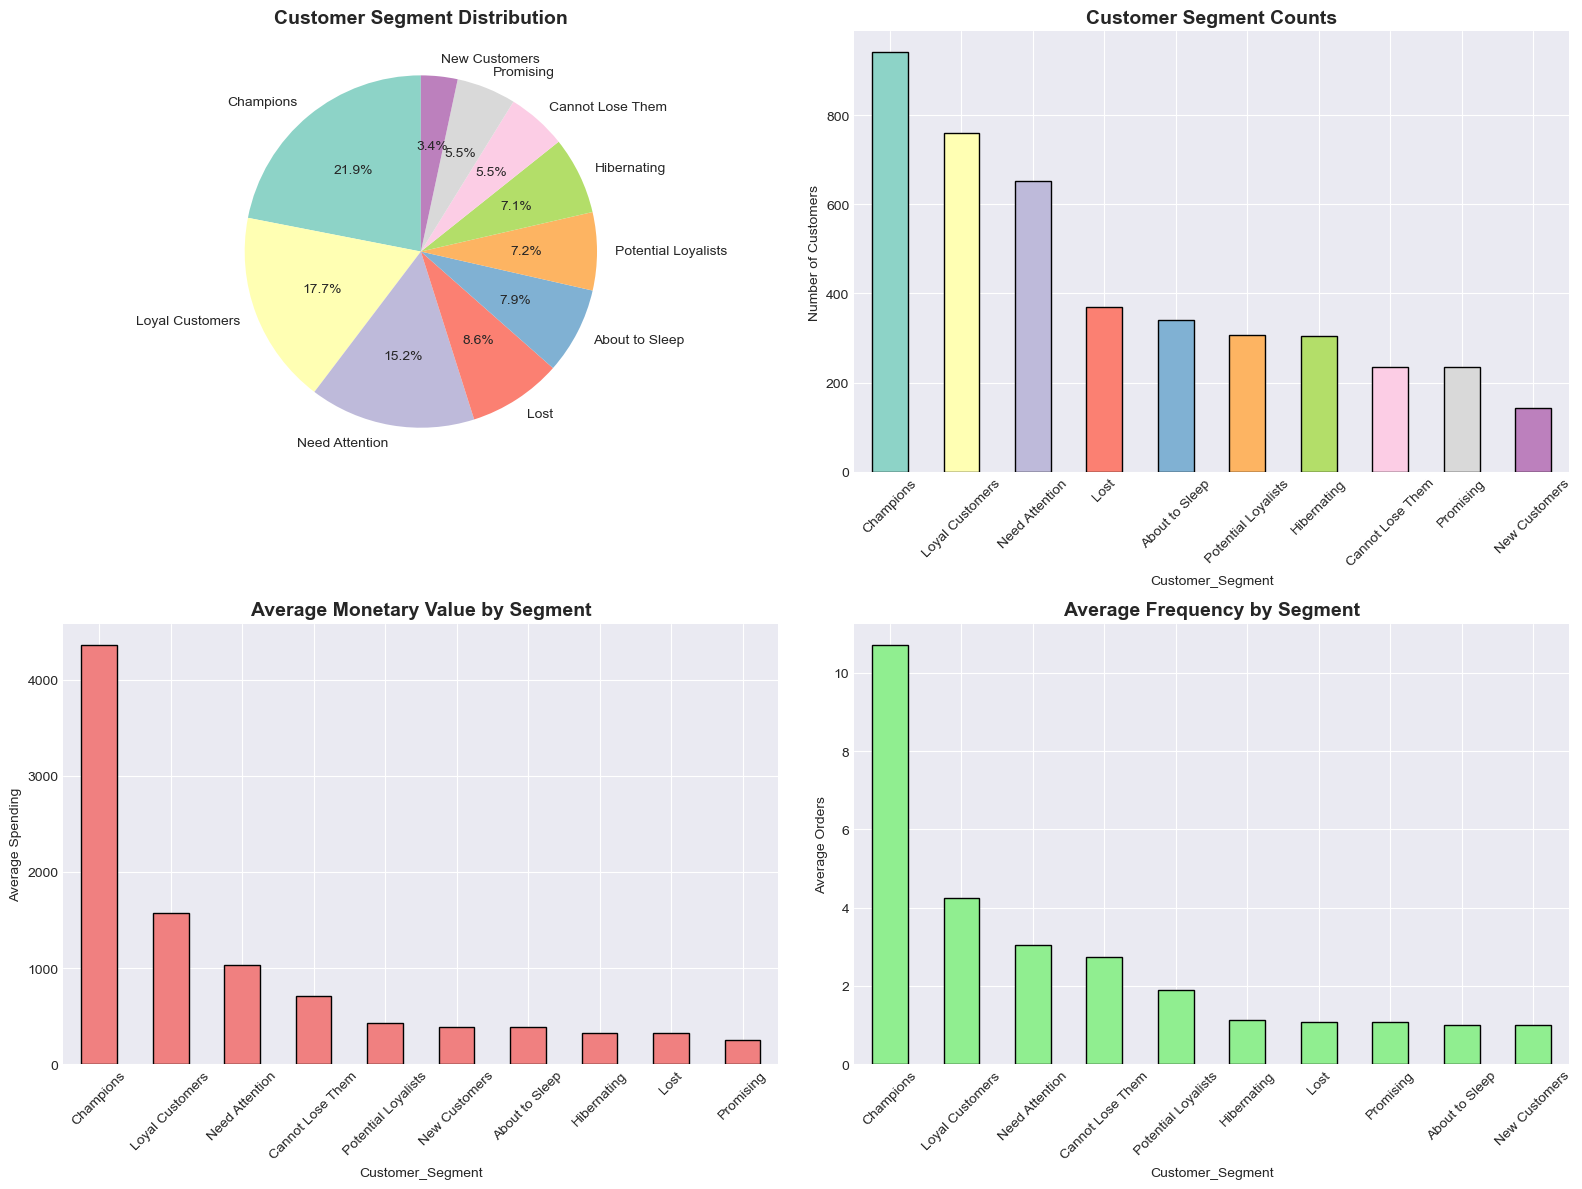

Customer Segment Summary:

Champions:
  Count: 941 (21.93%)
  Avg Monetary: $4362.48
  Avg Frequency: 10.7 orders
  Avg Recency: 17.1 days

Loyal Customers:
  Count: 761 (17.74%)
  Avg Monetary: $1568.19
  Avg Frequency: 4.2 orders
  Avg Recency: 45.0 days

Need Attention:
  Count: 653 (15.22%)
  Avg Monetary: $1032.45
  Avg Frequency: 3.0 orders
  Avg Recency: 119.1 days

Lost:
  Count: 369 (8.6%)
  Avg Monetary: $320.06
  Avg Frequency: 1.1 orders
  Avg Recency: 290.8 days

About to Sleep:
  Count: 341 (7.95%)
  Avg Monetary: $386.60
  Avg Frequency: 1.0 orders
  Avg Recency: 132.9 days

Potential Loyalists:
  Count: 307 (7.16%)
  Avg Monetary: $433.89
  Avg Frequency: 1.9 orders
  Avg Recency: 21.1 days

Hibernating:
  Count: 305 (7.11%)
  Avg Monetary: $329.70
  Avg Frequency: 1.1 orders
  Avg Recency: 308.5 days

Cannot Lose Them:
  Count: 235 (5.48%)
  Avg Monetary: $705.29
  Avg Frequency: 2.7 orders
  Avg Recency: 237.7 days

Promising:
  Count: 234 (5.45%)
  Avg Monetary: $250

In [14]:
# 3.1.3 Customer Segmentation Analysis Based on RFM
# Create manual RFM segments for comparison
def segment_customers(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Champions'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 4 and row['F_Score'] >= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 4 and row['F_Score'] == 1:
        return 'New Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] <= 2 and row['M_Score'] <= 2:
        return 'Promising'
    elif row['R_Score'] >= 2 and row['F_Score'] >= 2 and row['M_Score'] >= 2:
        return 'Need Attention'
    elif row['R_Score'] >= 2 and row['F_Score'] <= 2:
        return 'About to Sleep'
    elif row['R_Score'] <= 2 and row['F_Score'] >= 3:
        return 'Cannot Lose Them'
    elif row['R_Score'] <= 2 and row['F_Score'] == 2:
        return 'Hibernating'
    else:
        return 'Lost'

# Apply segmentation
rfm['Customer_Segment'] = rfm.apply(segment_customers, axis=1)

# Segment distribution
segment_counts = rfm['Customer_Segment'].value_counts()
segment_percentages = (segment_counts / len(rfm) * 100).round(2)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Segment distribution pie chart
colors = plt.cm.Set3(range(len(segment_counts)))
axes[0, 0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', 
               colors=colors, startangle=90)
axes[0, 0].set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

# Segment distribution bar chart
segment_counts.plot(kind='bar', ax=axes[0, 1], color=colors, edgecolor='black')
axes[0, 1].set_title('Customer Segment Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average Monetary by Segment
segment_monetary = rfm.groupby('Customer_Segment')['Monetary'].mean().sort_values(ascending=False)
segment_monetary.plot(kind='bar', ax=axes[1, 0], color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Average Monetary Value by Segment', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Average Spending')
axes[1, 0].tick_params(axis='x', rotation=45)

# Average Frequency by Segment
segment_frequency = rfm.groupby('Customer_Segment')['Frequency'].mean().sort_values(ascending=False)
segment_frequency.plot(kind='bar', ax=axes[1, 1], color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Average Frequency by Segment', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Orders')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Customer Segment Summary:")
for segment in segment_counts.index:
    count = segment_counts[segment]
    percentage = segment_percentages[segment]
    avg_monetary = rfm[rfm['Customer_Segment'] == segment]['Monetary'].mean()
    avg_frequency = rfm[rfm['Customer_Segment'] == segment]['Frequency'].mean()
    avg_recency = rfm[rfm['Customer_Segment'] == segment]['Recency'].mean()
    
    print(f"\n{segment}:")
    print(f"  Count: {count} ({percentage}%)")
    print(f"  Avg Monetary: ${avg_monetary:.2f}")
    print(f"  Avg Frequency: {avg_frequency:.1f} orders")
    print(f"  Avg Recency: {avg_recency:.1f} days")

In [18]:
# Menyimpan hasil RFM Analysis ke file CSV
# Simpan dataframe RFM dengan semua kolom analisis
rfm_with_segments = rfm.copy()

# Buat nama file dengan timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"RFM_Analysis_Results_{timestamp}.csv"

# Simpan ke CSV
rfm_with_segments.to_csv(filename, index=True)

print(f"✅ Data RFM Analysis berhasil disimpan ke: {filename}")
print(f"📊 Total customers: {len(rfm_with_segments)}")
print(f"📋 Kolom yang disimpan: {list(rfm_with_segments.columns)}")

# Tampilkan preview data yang disimpan
print(f"\n📋 Preview data yang disimpan:")
print(rfm_with_segments.head())

✅ Data RFM Analysis berhasil disimpan ke: RFM_Analysis_Results_20251119_170204.csv
📊 Total customers: 4290
📋 Kolom yang disimpan: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Customer_Segment']

📋 Preview data yang disimpan:
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0     12347.0       41          7   4060.40        4        5        5   
1     12348.0       77          4   1557.24        3        4        4   
2     12349.0       20          1   1457.55        4        1        4   
3     12350.0      312          1    334.40        1        1        2   
4     12352.0       74          8   1849.49        3        5        4   

   RFM_Score Customer_Segment  
0         14        Champions  
1         11  Loyal Customers  
2          9    New Customers  
3          4             Lost  
4         12  Loyal Customers  


📊 ANALISIS TOTAL FREKUENSI RFM
🔢 Total Frekuensi (Semua Transaksi): 18,018
👥 Total Customer: 4,290
📈 Rata-rata Frekuensi per Customer: 4.20
📊 Frekuensi Tertinggi: 207
📉 Frekuensi Terendah: 1

📋 DISTRIBUSI FREKUENSI:
Frequency
1     1486
2      830
3      493
4      384
5      235
6      176
7      136
8      102
9       65
10      59
Name: count, dtype: int64

🏆 TOP 5 CUSTOMER DENGAN FREKUENSI TERTINGGI:
      CustomerID  Frequency   Monetary Customer_Segment
325      12748.0        207   31054.95        Champions
1867     14911.0        199  130068.04        Champions
3970     17841.0        124   40001.57        Champions
557      13089.0         94   53551.99        Champions
1649     14606.0         93   12156.65        Champions


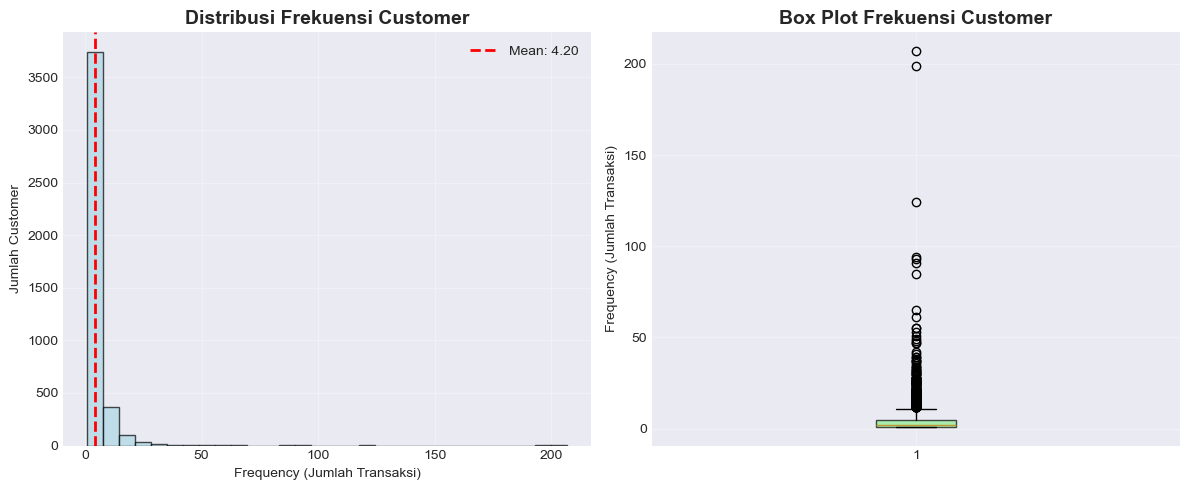

In [19]:
# Menghitung Total Frekuensi dari Semua Data RFM
total_frequency = rfm['Frequency'].sum()
total_customers = len(rfm)
avg_frequency_per_customer = rfm['Frequency'].mean()
max_frequency = rfm['Frequency'].max()
min_frequency = rfm['Frequency'].min()

print("📊 ANALISIS TOTAL FREKUENSI RFM")
print("=" * 50)
print(f"🔢 Total Frekuensi (Semua Transaksi): {total_frequency:,}")
print(f"👥 Total Customer: {total_customers:,}")
print(f"📈 Rata-rata Frekuensi per Customer: {avg_frequency_per_customer:.2f}")
print(f"📊 Frekuensi Tertinggi: {max_frequency}")
print(f"📉 Frekuensi Terendah: {min_frequency}")

# Distribusi Frekuensi
print(f"\n📋 DISTRIBUSI FREKUENSI:")
frequency_distribution = rfm['Frequency'].value_counts().sort_index()
print(frequency_distribution.head(10))

# Customer dengan frekuensi tertinggi
top_frequent_customers = rfm.nlargest(5, 'Frequency')[['CustomerID', 'Frequency', 'Monetary', 'Customer_Segment']]
print(f"\n🏆 TOP 5 CUSTOMER DENGAN FREKUENSI TERTINGGI:")
print(top_frequent_customers)

# Visualisasi
plt.figure(figsize=(12, 5))

# Subplot 1: Histogram distribusi frekuensi
plt.subplot(1, 2, 1)
plt.hist(rfm['Frequency'], bins=30, color='lightblue', edgecolor='black', alpha=0.7)
plt.axvline(avg_frequency_per_customer, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {avg_frequency_per_customer:.2f}')
plt.title('Distribusi Frekuensi Customer', fontsize=14, fontweight='bold')
plt.xlabel('Frequency (Jumlah Transaksi)')
plt.ylabel('Jumlah Customer')
plt.legend()
plt.grid(alpha=0.3)

# Subplot 2: Box plot frekuensi
plt.subplot(1, 2, 2)
plt.boxplot(rfm['Frequency'], patch_artist=True, 
           boxprops=dict(facecolor='lightgreen', alpha=0.7))
plt.title('Box Plot Frekuensi Customer', fontsize=14, fontweight='bold')
plt.ylabel('Frequency (Jumlah Transaksi)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# PENJELASAN: Mengapa Data Berkurang dari 393,915 menjadi 4,290?
print("🔍 ANALISIS TRANSFORMASI DATA: SEBELUM vs SESUDAH RFM")
print("=" * 60)

# Data sebelum RFM (raw transactional data)
print("📊 DATA SEBELUM RFM ANALYSIS:")
print(f"   • Total rows/records: {len(df_clean):,} transaksi")
print(f"   • Unique customers: {df_clean['CustomerID'].nunique():,} customer")
print(f"   • Unique products: {df_clean['StockCode'].nunique():,} produk")
print(f"   • Format: Transactional data (setiap row = 1 transaksi)")

print("\n" + "="*60)

# Data setelah RFM (customer-level aggregated data)
print("📈 DATA SETELAH RFM ANALYSIS:")
print(f"   • Total rows/records: {len(rfm):,} customer")
print(f"   • Format: Customer-level data (setiap row = 1 customer)")

print("\n" + "="*60)

print("💡 PENJELASAN TRANSFORMASI DATA:")
print("""
🔄 PROSES TRANSFORMASI:
   1. Data AWAL: Transactional Level
      - Setiap baris = 1 transaksi produk
      - Satu customer bisa punya banyak baris (multiple purchases)
      - Total: 393,915 transaksi individual
   
   2. Data RFM: Customer Level  
      - Agregasi semua transaksi per customer
      - Setiap baris = 1 customer unik
      - Total: 4,290 customer unik
      
📋 CONTOH TRANSFORMASI:
   Sebelum RFM:
   CustomerID | InvoiceNo | Product | Quantity | Price
   12345      | INV001    | A       | 2        | 10.0
   12345      | INV001    | B       | 1        | 15.0  
   12345      | INV002    | C       | 3        | 8.0
   → 3 baris untuk customer 12345
   
   Setelah RFM:
   CustomerID | Recency | Frequency | Monetary
   12345      | 45      | 2         | 39.0
   → 1 baris untuk customer 12345 (agregasi semua transaksi)

✅ KESIMPULAN:
   - 393,915 transaksi berasal dari 4,290 customer unik
   - Rata-rata: {(len(df_clean) / len(rfm)):.1f} transaksi per customer
   - Ini adalah transformasi NORMAL dalam RFM analysis!
""")

# Verifikasi konsistensi data
print("\n🔍 VERIFIKASI KONSISTENSI:")
customers_before = df_clean['CustomerID'].nunique()
customers_after = len(rfm)
total_transactions_original = len(df_clean)
total_frequency_rfm = rfm['Frequency'].sum()

print(f"✅ Customer unik sebelum RFM: {customers_before:,}")
print(f"✅ Customer unik setelah RFM:  {customers_after:,}")
print(f"✅ Konsistensi customer: {'MATCH' if customers_before == customers_after else 'ERROR'}")

print(f"\n✅ Total transaksi original: {total_transactions_original:,}")  
print(f"✅ Total frequency RFM:      {total_frequency_rfm:,}")
print(f"✅ Konsistensi transaksi: {'MATCH' if total_transactions_original == total_frequency_rfm else 'TIDAK MATCH - Perlu investigasi'}")

# Tampilkan sample transformasi
print(f"\n📋 CONTOH TRANSFORMASI CUSTOMER (Sample Customer ID: {rfm.iloc[0]['CustomerID']}):")
sample_customer = rfm.iloc[0]['CustomerID']
sample_transactions = df_clean[df_clean['CustomerID'] == sample_customer][['InvoiceNo', 'StockCode', 'Quantity', 'TotalPrice', 'InvoiceDate']].head()
sample_rfm = rfm[rfm['CustomerID'] == sample_customer]

print("\nTransaksi individual customer ini:")
print(sample_transactions)
print(f"\nSetelah agregasi RFM:")
print(sample_rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary']])

🔍 ANALISIS TRANSFORMASI DATA: SEBELUM vs SESUDAH RFM
📊 DATA SEBELUM RFM ANALYSIS:
   • Total rows/records: 393,915 transaksi
   • Unique customers: 4,290 customer
   • Unique products: 3,662 produk
   • Format: Transactional data (setiap row = 1 transaksi)

📈 DATA SETELAH RFM ANALYSIS:
   • Total rows/records: 4,290 customer
   • Format: Customer-level data (setiap row = 1 customer)

💡 PENJELASAN TRANSFORMASI DATA:

🔄 PROSES TRANSFORMASI:
   1. Data AWAL: Transactional Level
      - Setiap baris = 1 transaksi produk
      - Satu customer bisa punya banyak baris (multiple purchases)
      - Total: 393,915 transaksi individual

   2. Data RFM: Customer Level  
      - Agregasi semua transaksi per customer
      - Setiap baris = 1 customer unik
      - Total: 4,290 customer unik

📋 CONTOH TRANSFORMASI:
   Sebelum RFM:
   CustomerID | InvoiceNo | Product | Quantity | Price
   12345      | INV001    | A       | 2        | 10.0
   12345      | INV001    | B       | 1        | 15.0  
   12345

In [25]:
# 🚨 INVESTIGASI KETIDAKSESUAIAN FREKUENSI 
print("🔍 INVESTIGASI MASALAH FREKUENSI")
print("=" * 60)

# Problem: Total transaksi original (393,915) vs Total frequency RFM (18,018)
print("❌ MASALAH YANG DITEMUKAN:")
print(f"   • Total transaksi original: {len(df_clean):,}")
print(f"   • Total frequency RFM: {rfm['Frequency'].sum():,}")
print(f"   • Selisih: {len(df_clean) - rfm['Frequency'].sum():,} transaksi")

print(f"\n🔍 ANALISIS PENYEBAB:")

# 1. Cek apakah frequency menghitung InvoiceNo atau baris transaksi
print("1. CARA PERHITUNGAN FREQUENCY SAAT INI:")
print("   • RFM Frequency = InvoiceNo.nunique() per customer")
print("   • Artinya menghitung JUMLAH INVOICE, bukan JUMLAH TRANSAKSI PRODUK")

# 2. Contoh customer untuk menunjukkan perbedaan
sample_customer = 12347.0
customer_data = df_clean[df_clean['CustomerID'] == sample_customer]
unique_invoices = customer_data['InvoiceNo'].nunique()
total_transactions = len(customer_data)

print(f"\n2. CONTOH CUSTOMER {sample_customer}:")
print(f"   • Total baris transaksi: {total_transactions}")
print(f"   • Unique InvoiceNo: {unique_invoices}")
print(f"   • RFM Frequency (dari perhitungan): {rfm[rfm['CustomerID'] == sample_customer]['Frequency'].iloc[0]}")

print(f"\n3. PENJELASAN PERBEDAAN:")
print(f"   • 1 Invoice bisa berisi MULTIPLE produk")
print(f"   • Customer beli 5 produk dalam 1 invoice = 5 baris transaksi, 1 frequency")
print(f"   • Ini BENAR untuk RFM Analysis karena frequency = jumlah pembelian (sessions)")

# 4. Verifikasi konsistensi
print(f"\n🔍 VERIFIKASI KONSISTENSI YANG BENAR:")

# Hitung total unique invoices dari semua customer
total_unique_invoices = df_clean['InvoiceNo'].nunique()
total_frequency_rfm = rfm['Frequency'].sum()

print(f"✅ Total unique InvoiceNo dalam dataset: {total_unique_invoices:,}")
print(f"✅ Total frequency RFM: {total_frequency_rfm:,}")
print(f"✅ Konsistensi Invoice: {'MATCH' if total_unique_invoices == total_frequency_rfm else 'TIDAK MATCH'}")

# 5. Tampilkan breakdown per customer sample
print(f"\n📊 BREAKDOWN CUSTOMER {sample_customer}:")
customer_invoices = customer_data.groupby('InvoiceNo').agg({
    'StockCode': 'count',  # Jumlah produk per invoice
    'TotalPrice': 'sum',   # Total nilai per invoice
    'InvoiceDate': 'first' # Tanggal invoice
}).round(2)
customer_invoices.columns = ['Jumlah_Produk', 'Total_Nilai', 'Tanggal']
print(customer_invoices.head())

print(f"\n✅ KESIMPULAN:")
print(f"   • Frequency RFM = Jumlah PEMBELIAN (Invoice), bukan jumlah produk")
print(f"   • 393,915 baris = transaksi produk individual")
print(f"   • {total_frequency_rfm:,} frequency = jumlah session pembelian")
print(f"   • Rata-rata {(len(df_clean) / total_frequency_rfm):.1f} produk per invoice")
print(f"   • Ini adalah perhitungan yang BENAR untuk RFM Analysis!")

🔍 INVESTIGASI MASALAH FREKUENSI
❌ MASALAH YANG DITEMUKAN:
   • Total transaksi original: 393,915
   • Total frequency RFM: 18,018
   • Selisih: 375,897 transaksi

🔍 ANALISIS PENYEBAB:
1. CARA PERHITUNGAN FREQUENCY SAAT INI:
   • RFM Frequency = InvoiceNo.nunique() per customer
   • Artinya menghitung JUMLAH INVOICE, bukan JUMLAH TRANSAKSI PRODUK

2. CONTOH CUSTOMER 12347.0:
   • Total baris transaksi: 181
   • Unique InvoiceNo: 7
   • RFM Frequency (dari perhitungan): 7

3. PENJELASAN PERBEDAAN:
   • 1 Invoice bisa berisi MULTIPLE produk
   • Customer beli 5 produk dalam 1 invoice = 5 baris transaksi, 1 frequency
   • Ini BENAR untuk RFM Analysis karena frequency = jumlah pembelian (sessions)

🔍 VERIFIKASI KONSISTENSI YANG BENAR:
✅ Total unique InvoiceNo dalam dataset: 18,018
✅ Total frequency RFM: 18,018
✅ Konsistensi Invoice: MATCH

📊 BREAKDOWN CUSTOMER 12347.0:
           Jumlah_Produk  Total_Nilai             Tanggal
InvoiceNo                                                
537626 

### 📊 PENJELASAN CUSTOMER SEGMENTATION dalam RFM Analysis

Customer Segmentation dalam RFM Analysis ditentukan berdasarkan **kombinasi dari 3 skor RFM (R_Score, F_Score, M_Score)** yang masing-masing memiliki nilai 1-5. Berikut penjelasan lengkapnya:

In [26]:
# 📊 PENJELASAN LENGKAP CUSTOMER SEGMENTATION DALAM RFM

print("🎯 PENENTUAN CUSTOMER SEGMENTATION BERDASARKAN:")
print("=" * 70)

print("1️⃣ KOMPONEN RFM SCORES:")
print("   • R_Score (Recency): 1-5 (5 = Paling Recent)")
print("   • F_Score (Frequency): 1-5 (5 = Paling Frequent)")  
print("   • M_Score (Monetary): 1-5 (5 = Paling Tinggi Value)")

print(f"\n2️⃣ CARA PERHITUNGAN SKOR:")
print("   • Recency: Dibagi menjadi 5 quintile, skor 5 = recency terendah (terbaru)")
print("   • Frequency: Dibagi menjadi 5 quintile, skor 5 = frequency tertinggi")
print("   • Monetary: Dibagi menjadi 5 quintile, skor 5 = monetary tertinggi")

print(f"\n3️⃣ LOGIKA SEGMENTASI BERDASARKAN KOMBINASI RFM:")

segments_logic = {
    "Champions": "R≥4 AND F≥4 AND M≥4",
    "Loyal Customers": "R≥3 AND F≥3 AND M≥3", 
    "Potential Loyalists": "R≥4 AND F≥2",
    "New Customers": "R≥4 AND F=1",
    "Promising": "R≥3 AND F≤2 AND M≤2",
    "Need Attention": "R≥2 AND F≥2 AND M≥2",
    "About to Sleep": "R≥2 AND F≤2",
    "Cannot Lose Them": "R≤2 AND F≥3",
    "Hibernating": "R≤2 AND F=2",
    "Lost": "Lainnya (R≤2 AND F=1)"
}

for segment, logic in segments_logic.items():
    print(f"   • {segment:20}: {logic}")

print(f"\n4️⃣ INTERPRETASI BISNIS SETIAP SEGMEN:")
segment_meanings = {
    "Champions": "Customer terbaik - beli recent, sering, dan nilai tinggi",
    "Loyal Customers": "Customer setia - perlu maintenance relationship", 
    "Potential Loyalists": "Beli recent tapi belum sering - potensial jadi loyal",
    "New Customers": "Customer baru - beli recent tapi baru 1x",
    "Promising": "Customer dengan potensi - recent tapi value rendah",
    "Need Attention": "Customer butuh perhatian - mulai menurun aktivitas",
    "About to Sleep": "Customer hampir tidak aktif - perlu re-engagement",
    "Cannot Lose Them": "Customer valuable tapi jarang beli - jangan sampai hilang",
    "Hibernating": "Customer 'tidur' - sudah lama tidak beli",
    "Lost": "Customer hilang - sudah sangat lama (>1 tahun tidak beli)"
}

for segment, meaning in segment_meanings.items():
    print(f"   • {segment:20}: {meaning}")

print(f"\n5️⃣ CONTOH PERHITUNGAN SEGMENTASI:")
# Ambil sample data untuk dijelaskan
sample_data = rfm[['CustomerID', 'R_Score', 'F_Score', 'M_Score', 'Customer_Segment']].head()
print(sample_data)

print(f"\n6️⃣ DISTRIBUSI SEGMEN SAAT INI:")
segment_counts = rfm['Customer_Segment'].value_counts()
for segment, count in segment_counts.items():
    percentage = (count / len(rfm) * 100)
    print(f"   • {segment:20}: {count:4d} customer ({percentage:5.1f}%)")

print(f"\n7️⃣ STRATEGI MARKETING PER SEGMEN:")
marketing_strategies = {
    "Champions": "Reward program, referral program, upselling premium products",
    "Loyal Customers": "Loyalty program, personalized offers, early access", 
    "Potential Loyalists": "Membership program, cross-selling, frequency incentives",
    "New Customers": "Onboarding program, first purchase discount, education",
    "Promising": "Value proposition, bundle offers, category expansion",
    "Need Attention": "Limited time offers, reactivation campaign, personalized deals",
    "About to Sleep": "Win-back campaign, special discounts, engagement survey",
    "Cannot Lose Them": "VIP treatment, exclusive offers, high-touch service",
    "Hibernating": "Aggressive discounts, new product launch, re-engagement",
    "Lost": "Win-back dengan deep discount, survey exit reason"
}

for segment, strategy in marketing_strategies.items():
    if segment in segment_counts.index:  # Only show segments that exist in data
        print(f"   • {segment:20}: {strategy}")

print(f"\n✅ KESIMPULAN:")
print("   Customer Segmentation RFM menggunakan RULE-BASED APPROACH")
print("   berdasarkan kombinasi logis dari 3 dimensi perilaku customer")
print("   untuk menghasilkan 10 segmen yang actionable untuk marketing strategy!")

🎯 PENENTUAN CUSTOMER SEGMENTATION BERDASARKAN:
1️⃣ KOMPONEN RFM SCORES:
   • R_Score (Recency): 1-5 (5 = Paling Recent)
   • F_Score (Frequency): 1-5 (5 = Paling Frequent)
   • M_Score (Monetary): 1-5 (5 = Paling Tinggi Value)

2️⃣ CARA PERHITUNGAN SKOR:
   • Recency: Dibagi menjadi 5 quintile, skor 5 = recency terendah (terbaru)
   • Frequency: Dibagi menjadi 5 quintile, skor 5 = frequency tertinggi
   • Monetary: Dibagi menjadi 5 quintile, skor 5 = monetary tertinggi

3️⃣ LOGIKA SEGMENTASI BERDASARKAN KOMBINASI RFM:
   • Champions           : R≥4 AND F≥4 AND M≥4
   • Loyal Customers     : R≥3 AND F≥3 AND M≥3
   • Potential Loyalists : R≥4 AND F≥2
   • New Customers       : R≥4 AND F=1
   • Promising           : R≥3 AND F≤2 AND M≤2
   • Need Attention      : R≥2 AND F≥2 AND M≥2
   • About to Sleep      : R≥2 AND F≤2
   • Cannot Lose Them    : R≤2 AND F≥3
   • Hibernating         : R≤2 AND F=2
   • Lost                : Lainnya (R≤2 AND F=1)

4️⃣ INTERPRETASI BISNIS SETIAP SEGMEN:
   •

In [23]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4290 entries, 0 to 4289
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        4290 non-null   float64
 1   Recency           4290 non-null   int64  
 2   Frequency         4290 non-null   int64  
 3   Monetary          4290 non-null   float64
 4   R_Score           4290 non-null   int64  
 5   F_Score           4290 non-null   int64  
 6   M_Score           4290 non-null   int64  
 7   RFM_Score         4290 non-null   int64  
 8   Customer_Segment  4290 non-null   object 
dtypes: float64(2), int64(6), object(1)
memory usage: 301.8+ KB


In [15]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,12347.0,41,7,4060.40,4,5,5,14,Champions
1,12348.0,77,4,1557.24,3,4,4,11,Loyal Customers
2,12349.0,20,1,1457.55,4,1,4,9,New Customers
3,12350.0,312,1,334.40,1,1,2,4,Lost
4,12352.0,74,8,1849.49,3,5,4,12,Loyal Customers


In [16]:
rfm.Customer_Segment.unique()

array(['Champions', 'Loyal Customers', 'New Customers', 'Lost',
       'About to Sleep', 'Potential Loyalists', 'Hibernating',
       'Need Attention', 'Promising', 'Cannot Lose Them'], dtype=object)